In [197]:
# Authors: Rahul Ramachandran and Rishit D

# Importing the required libraries
try:
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_validate
    import scipy
    import matplotlib.pyplot as plt
except:
    print(f'[INFO] Installing the required libraries')
    !pip install numpy
    !pip install pandas
    !pip install scikit-learn
    !pip install scipy
    !pip install matplotlib
    import numpy as np
    import pandas as pd
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_validate
    from scipy.stats import poisson
    import matplotlib.pyplot as plt

In [198]:
# Toy data
X = np.array([[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]]).T # shape = (10, 1)
theta = np.array([[1, 2]]).T # shape = (2, 1)
# # Concatentate a column of ones to X
X_c = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) # shape = (10, 2)
# Generate the response variable y
y = np.exp(X_c @ theta)# shape = (10, 1)
y

array([[ 3.32011692],
       [ 4.05519997],
       [ 4.95303242],
       [ 6.04964746],
       [ 7.3890561 ],
       [ 9.0250135 ],
       [11.02317638],
       [13.46373804],
       [16.44464677],
       [20.08553692]])

In [199]:
from typing import List

class PoissonRegression:

    def __init__(self, dim:int, alpha:float=0.01, n_iter:int=1000, lambda_:float=0.1, weights:np.ndarray=None):
        """
            dim: Dimension of the data
            alpha: Learning rate
            n_iter: Max Number of iterations
            lambda_: Regularization parameter
            weights: Initial weights
        """
        if weights is not None:
            self.theta = weights
            assert self.theta.shape == (dim+1, 1)
        else:
            self.theta = np.zeros((dim+1, 1)) # include the bias term
        self.alpha = alpha
        self.n_iter = n_iter
        self.lambda_ = lambda_
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        """Fits the model (theta) to the data
            params:
                X: shape = (n, dim)
                y: shape = (n, 1)
            returns:
                List of losses
                Weight vector theta
        """
        losses = []

        # Concatenate a column of ones to X
        X_c = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1) # shape = (n, dim+1)

        for iter in range(self.n_iter):
            # Calculate the loss (ignore the constant factorial term)
            loss = -np.sum(y * (X_c @ self.theta) - np.exp(X_c @ self.theta)) + self.lambda_ * np.sum(self.theta**2)
            losses.append(loss)

            # Update theta
            self.theta -= -self.alpha * (X_c.T @ (y - np.exp(X_c @ self.theta))) + 2 * self.lambda_ * self.theta
        
        return losses, self.theta
    
    def predict(self, X:np.ndarray)->np.ndarray:
        """Predicts the response variable
            params:
                X: shape = (n, dim)
            returns:
                y_pred: shape = (n, 1)
        """
        # Concatenate a column of ones to X
        X_c = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y_pred = np.exp(X_c @ self.theta)
        return y_pred



[10.0, -90.39776254937064, -131.456616637732, -132.76743979317283, -133.07327484455226, -133.28140294001832, -133.45338529103188, -133.60578971159487, -133.742650828994, -133.86597018425925]


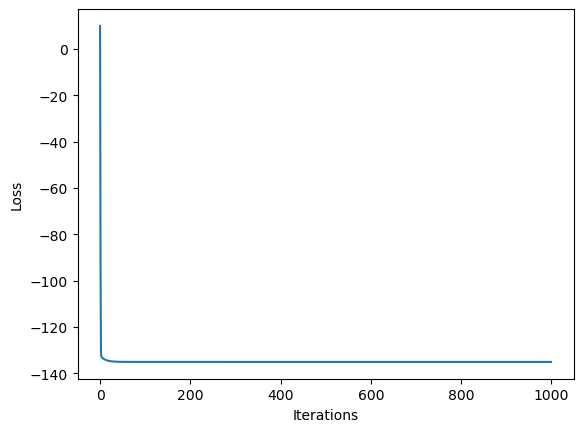

In [200]:
# Fit the model
poisson = PoissonRegression(dim=1, alpha=1e-2, n_iter=1000, lambda_=0)
losses, _ = poisson.fit(X, y)
y_pred = poisson.predict(X)

# Plot the losses
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
print(losses[:10])

In [201]:
# Plot the predictions
y_pred_poisson = poisson.predict(X)
y_pred_poisson - y

array([[ 6.21724894e-15],
       [ 6.21724894e-15],
       [ 6.21724894e-15],
       [ 5.32907052e-15],
       [ 6.21724894e-15],
       [ 0.00000000e+00],
       [ 3.55271368e-15],
       [-5.32907052e-15],
       [ 0.00000000e+00],
       [-1.77635684e-14]])

In [202]:
# Compare with linear regression
linear = LinearRegression()
linear.fit(X, y)
y_pred_linear = linear.predict(X)
y_pred_linear - y

array([[-1.83169992],
       [-0.76844976],
       [ 0.132051  ],
       [ 0.83376917],
       [ 1.29269374],
       [ 1.45506955],
       [ 1.25523988],
       [ 0.61301144],
       [-0.56956408],
       [-2.41212102]])

In [203]:
# Get data from the csv file
df = pd.read_csv('final_data.csv')

# Randomly select 80% of the data for training
train = df.sample(frac=0.8, random_state=3)
test = df.drop(train.index)
X_train, y_train = np.array(train[["Day","Company","Ordered","Event After"]]), np.array(train["Duration"])[:, np.newaxis]
X_test, y_test = np.array(test[["Day","Company","Ordered","Event After"]]), np.array(test["Duration"])[:, np.newaxis]
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60, 4) (60, 1) (15, 4) (15, 1)


-4214.8696236360665
[[ 2.69941828]
 [ 0.03182905]
 [ 0.64998092]
 [ 0.35137632]
 [-0.0190624 ]]
1.7471475539352415
7.820186667593069


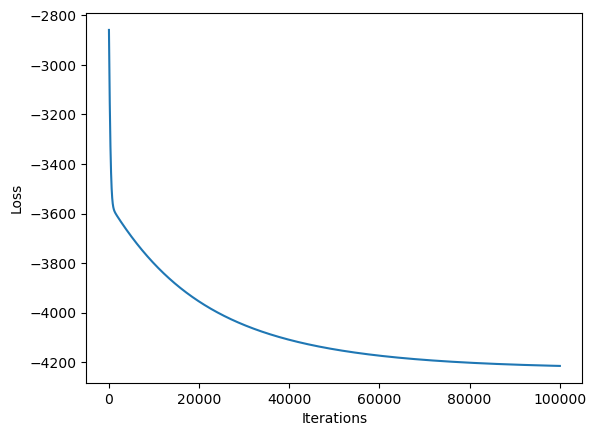

In [204]:
# Fit the model
poisson = PoissonRegression(dim=4, alpha=1e-7, n_iter=100000, lambda_=1e-8, weights=np.array([[1., 0., 1., 1., -1.]]).T)
losses, weights = poisson.fit(X_train, y_train)

# Plot the losses
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
print(losses[-1])
print(weights)

# Find mean absolute error on the test set
y_pred_pos = poisson.predict(X_test)
mae = np.mean(np.abs(y_pred_pos - y_test))
# print(y_pred - y_test)
print(mae)
# Find mean squared error on the test set
mse = np.mean((y_pred_pos - y_test)**2)
print(mse)

In [210]:
# Fit linear regression
linear = LinearRegression()
vals = linear.fit(X_train, y_train)
print(vals.coef_, vals.intercept_)
y_pred_lin = linear.predict(X_test)

# Cross-validate
cv_results = cross_validate(linear, train[["Day","Company","Ordered","Event After"]], train["Duration"], cv=5)
print(sorted(cv_results.keys()))
print(cv_results)

# Find mean absolute error on the test set
mae = np.mean(np.abs(y_pred_lin - y_test))
print(mae)
# Find mean squared error on the test set
mse = np.mean((y_pred_lin - y_test)**2)
print(mse)

[[ 0.5577566  12.32268965  6.98542006 -1.99081043]] [18.49151664]
['fit_time', 'score_time', 'test_score']
{'fit_time': array([0.00304508, 0.0014987 , 0.00162554, 0.00136781, 0.00176287]), 'score_time': array([0.00180531, 0.00125742, 0.00106859, 0.00106049, 0.00121951]), 'test_score': array([0.51305541, 0.53829155, 0.17791021, 0.85464919, 0.62362679])}
2.637805350449049
10.122334268305952


In [206]:
# print(y_pred_lin - y_pred_pos)
# print(y_test - y_pred_pos)
# print(y_test)
# print(X_test)

new_data = np.concatenate((y_pred_lin - y_pred_pos, y_test - y_pred_pos, y_test, X_test), axis=1)
pd.DataFrame(new_data, columns=["Linear", "Target", "Duration", "P1", "P2", "P3", "P4"])

,Linear,Target,Duration,P1,P2,P3,P4
0,0.529541,0.148389,29.0,1.0,1.0,0.0,1.0
1,2.182260,-0.107229,17.0,5.0,0.0,0.0,1.0
2,1.147755,0.660279,32.0,3.0,1.0,0.0,0.0
3,0.203372,-0.399617,33.0,5.0,1.0,0.0,0.0
4,3.620438,0.128922,15.0,0.0,0.0,0.0,0.0
5,-2.679058,-1.478684,39.0,0.0,1.0,1.0,0.0
6,1.996314,0.937851,16.0,1.0,0.0,0.0,1.0
7,3.758506,-1.848524,14.0,2.0,0.0,0.0,0.0
8,3.832328,1.109785,18.0,4.0,0.0,0.0,0.0
9,-4.224126,-0.139266,43.0,2.0,1.0,1.0,0.0
